# Notebook 5: Isolation Forest and Ensemble Models

## ML-Based Drone Firmware Tampering Detection System

This notebook covers:
- Isolation Forest for anomaly detection
- Random Forest classifier
- XGBoost classifier
- Ensemble voting classifier
- Model comparison
- Feature importance analysis


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import joblib

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not available. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Load processed data
DATA_DIR = Path('../data')
X_train = pd.read_csv(DATA_DIR / 'X_train.csv').values
X_test = pd.read_csv(DATA_DIR / 'X_test.csv').values
y_train = pd.read_csv(DATA_DIR / 'y_train.csv').values.ravel()
y_test = pd.read_csv(DATA_DIR / 'y_test.csv').values.ravel()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining label distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest label distribution:")
print(pd.Series(y_test).value_counts())


Training set: (1600, 30)
Test set: (400, 30)

Training label distribution:
1    800
0    800
Name: count, dtype: int64

Test label distribution:
0    200
1    200
Name: count, dtype: int64


In [ ]:
# 1. Isolation Forest
print("=" * 50)
print("Training Isolation Forest...")
print("=" * 50)

# Train on clean data only (anomaly detection)
X_train_clean = X_train[y_train == 1]

isolation_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,  # Expected proportion of anomalies
    random_state=42,
    n_jobs=-1
)

isolation_forest.fit(X_train_clean)

# Predict anomalies (-1 for anomaly, 1 for normal)
y_pred_iso = isolation_forest.predict(X_test)
# Convert to binary: -1 -> 0 (tampered), 1 -> 1 (clean)
y_pred_iso_binary = (y_pred_iso == 1).astype(int)

# Get anomaly scores (lower = more anomalous)
anomaly_scores = isolation_forest.score_samples(X_test)
# Convert to probabilities (normalize to 0-1, invert so higher = more tampered)
anomaly_scores_normalized = 1 - (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min() + 1e-6)

print("\nIsolation Forest Results:")
print(classification_report(y_test, y_pred_iso_binary, target_names=['Tampered', 'Clean']))
print(f"ROC AUC: {roc_auc_score(y_test, anomaly_scores_normalized):.4f}")


Training Isolation Forest...

Isolation Forest Results:
              precision    recall  f1-score   support

    Tampered       0.93      1.00      0.96       200
       Clean       1.00      0.92      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400

ROC AUC: 0.0136


In [ ]:
# 2. Random Forest Classifier
print("\n" + "=" * 50)
print("Training Random Forest Classifier...")
print("=" * 50)

random_forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
y_pred_proba_rf = random_forest.predict_proba(X_test)[:, 1]

print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf, target_names=['Tampered', 'Clean']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")



Training Random Forest Classifier...

Random Forest Results:
              precision    recall  f1-score   support

    Tampered       1.00      1.00      1.00       200
       Clean       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

ROC AUC: 1.0000


In [ ]:
# 3. XGBoost Classifier (if available)
if XGBOOST_AVAILABLE:
    print("\n" + "=" * 50)
    print("Training XGBoost Classifier...")
    print("=" * 50)
    
    xgboost_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    xgboost_model.fit(X_train, y_train)
    y_pred_xgb = xgboost_model.predict(X_test)
    y_pred_proba_xgb = xgboost_model.predict_proba(X_test)[:, 1]
    
    print("\nXGBoost Results:")
    print(classification_report(y_test, y_pred_xgb, target_names=['Tampered', 'Clean']))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
else:
    print("\nXGBoost not available. Skipping...")
    xgboost_model = None
    y_pred_xgb = None
    y_pred_proba_xgb = None



Training XGBoost Classifier...

XGBoost Results:
              precision    recall  f1-score   support

    Tampered       1.00      1.00      1.00       200
       Clean       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

ROC AUC: 1.0000


In [ ]:
# 4. Ensemble Voting Classifier
print("\n" + "=" * 50)
print("Training Ensemble Voting Classifier...")
print("=" * 50)

# Create ensemble with available models
estimators = [
    ('rf', random_forest)
]

if XGBOOST_AVAILABLE:
    estimators.append(('xgb', xgboost_model))

ensemble = VotingClassifier(
    estimators=estimators,
    voting='soft'  # Use probability voting
)

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
y_pred_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]

print("\nEnsemble Results:")
print(classification_report(y_test, y_pred_ensemble, target_names=['Tampered', 'Clean']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_ensemble):.4f}")



Training Ensemble Voting Classifier...

Ensemble Results:
              precision    recall  f1-score   support

    Tampered       1.00      1.00      1.00       200
       Clean       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

ROC AUC: 1.0000



Feature Importance Analysis

Top 15 Most Important Features (Random Forest):
                  feature  importance
1               is_signed    0.174812
27      high_entropy_flag    0.137235
17           boot_time_ms    0.116892
9           entropy_score    0.113800
10    avg_section_entropy    0.092773
11    max_section_entropy    0.082282
18      emulated_syscalls    0.078263
21    security_risk_score    0.077179
14     hardcoded_ip_count    0.034618
15    hardcoded_url_count    0.028901
16  crypto_function_count    0.023636
12        num_executables    0.012228
13            num_scripts    0.011143
2          signature_type    0.006674
28         long_boot_flag    0.005393


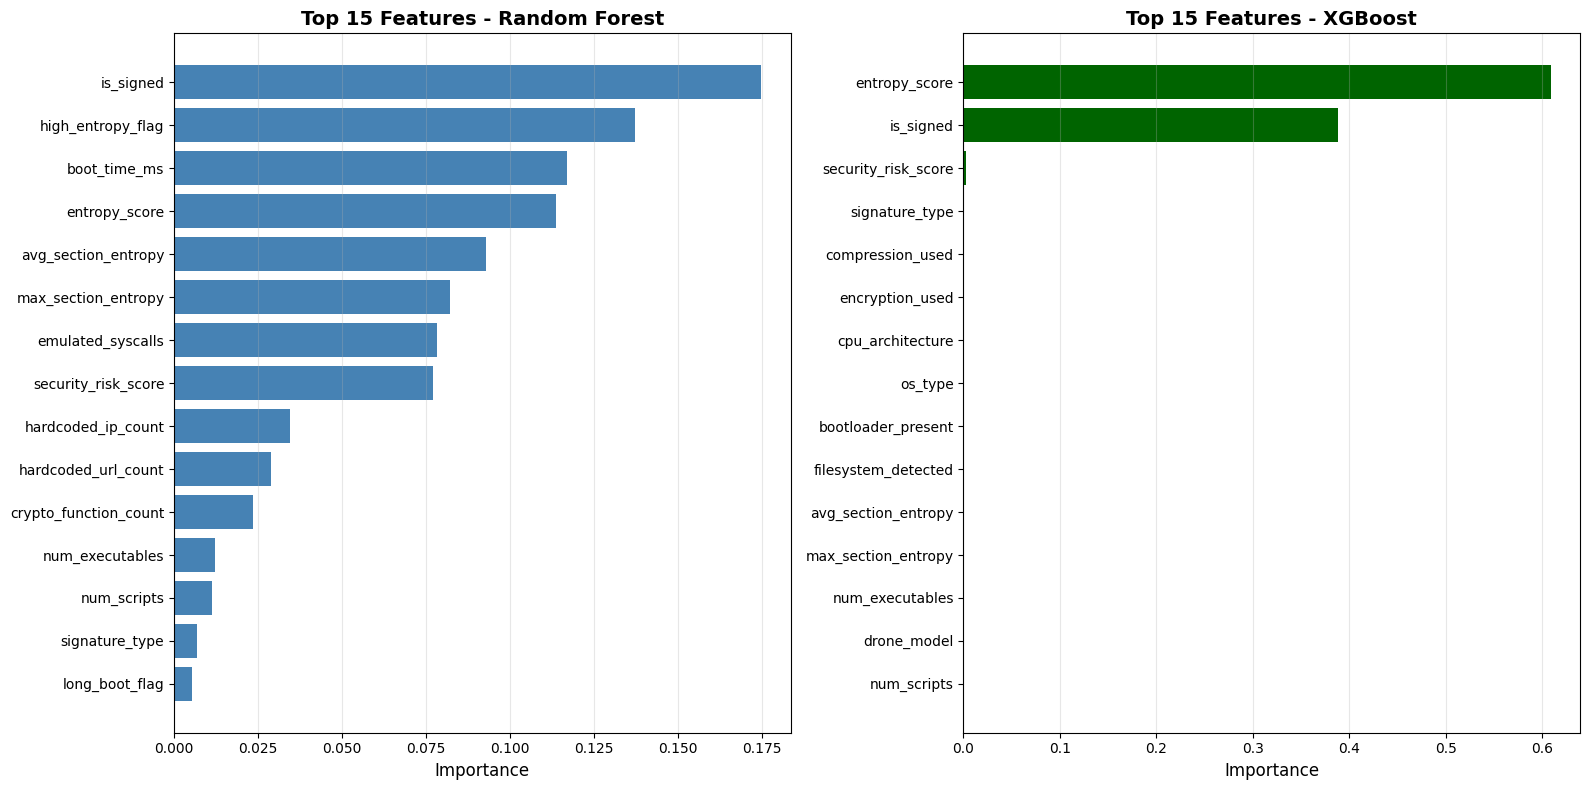

In [ ]:
# Feature Importance Analysis
print("\n" + "=" * 50)
print("Feature Importance Analysis")
print("=" * 50)

# Get feature names
feature_names = pd.read_csv(DATA_DIR / 'X_train.csv').columns.tolist()

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': random_forest.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (Random Forest):")
print(rf_importance.head(15))

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest
top_n = 15
rf_top = rf_importance.head(top_n)
axes[0].barh(range(len(rf_top)), rf_top['importance'], color='steelblue')
axes[0].set_yticks(range(len(rf_top)))
axes[0].set_yticklabels(rf_top['feature'])
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title(f'Top {top_n} Features - Random Forest', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# XGBoost (if available)
if XGBOOST_AVAILABLE:
    xgb_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': xgboost_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    xgb_top = xgb_importance.head(top_n)
    axes[1].barh(range(len(xgb_top)), xgb_top['importance'], color='darkgreen')
    axes[1].set_yticks(range(len(xgb_top)))
    axes[1].set_yticklabels(xgb_top['feature'])
    axes[1].set_xlabel('Importance', fontsize=12)
    axes[1].set_title(f'Top {top_n} Features - XGBoost', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')
else:
    axes[1].text(0.5, 0.5, 'XGBoost not available', 
                 ha='center', va='center', fontsize=14)
    axes[1].set_title('XGBoost Feature Importance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()



Model Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Isolation Forest,0.96,1.0,0.92,0.958333,0.01365
1,Random Forest,1.00,1.0,1.00,1.000000,1.00000
2,XGBoost,1.00,1.0,1.00,1.000000,1.00000
3,Ensemble,1.00,1.0,1.00,1.000000,1.00000


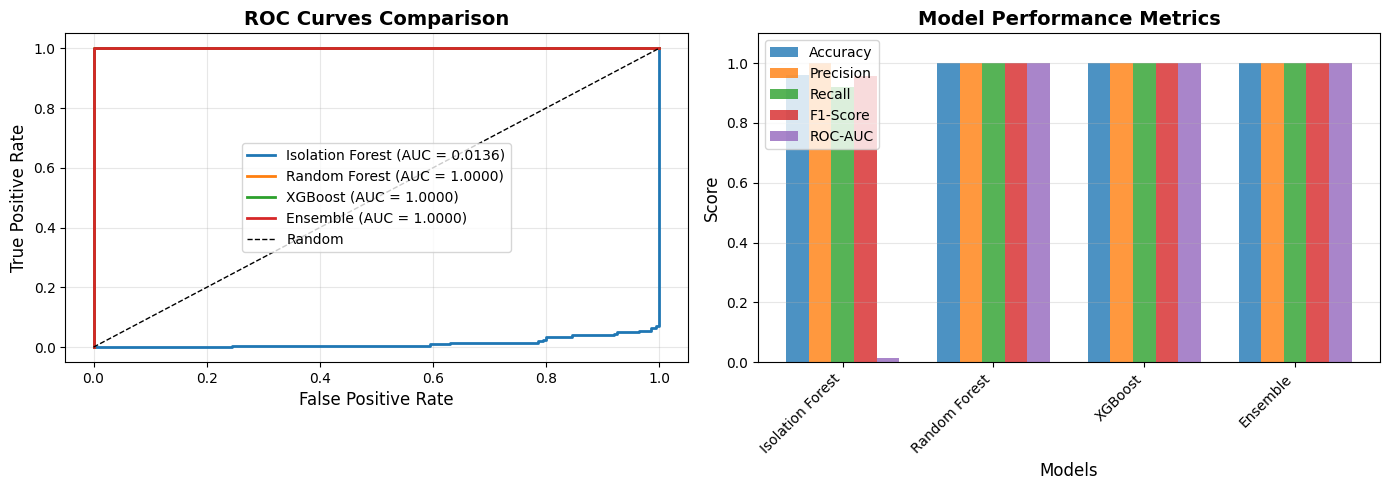

In [ ]:
# Visualize model performance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrices
models_data = [
    ('Isolation Forest', y_pred_iso_binary, anomaly_scores_normalized),
    ('Random Forest', y_pred_rf, y_pred_proba_rf),
    ('Ensemble', y_pred_ensemble, y_pred_proba_ensemble)
]

if XGBOOST_AVAILABLE:
    models_data.insert(2, ('XGBoost', y_pred_xgb, y_pred_proba_xgb))

# Plot ROC curves
for name, y_pred, y_proba in models_data:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    axes[0].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.4f})')

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Model comparison metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics_data = []
for name, y_pred, y_proba in models_data:
    metrics_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

metrics_df = pd.DataFrame(metrics_data)
print("\nModel Comparison:")
display(metrics_df)

# Bar plot of metrics
x = np.arange(len(metrics_df))
width = 0.15
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for i, metric in enumerate(metrics):
    axes[1].bar(x + i*width, metrics_df[metric], width, label=metric, alpha=0.8)

axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
axes[1].set_xticks(x + width * 2)
axes[1].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('../results/ensemble_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Save models and results
MODELS_DIR = Path('../models')
RESULTS_DIR = Path('../results')
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

# Save models
joblib.dump(isolation_forest, MODELS_DIR / 'isolation_forest_model.pkl')
print(f"Isolation Forest saved to {MODELS_DIR / 'isolation_forest_model.pkl'}")

joblib.dump(random_forest, MODELS_DIR / 'random_forest_model.pkl')
print(f"Random Forest saved to {MODELS_DIR / 'random_forest_model.pkl'}")

if XGBOOST_AVAILABLE:
    joblib.dump(xgboost_model, MODELS_DIR / 'xgboost_model.pkl')
    print(f"XGBoost saved to {MODELS_DIR / 'xgboost_model.pkl'}")

joblib.dump(ensemble, MODELS_DIR / 'ensemble_model.pkl')
print(f"Ensemble saved to {MODELS_DIR / 'ensemble_model.pkl'}")

# Save predictions
results_dict = {
    'isolation_forest': {
        'y_pred': y_pred_iso_binary,
        'y_proba': anomaly_scores_normalized
    },
    'random_forest': {
        'y_pred': y_pred_rf,
        'y_proba': y_pred_proba_rf
    },
    'ensemble': {
        'y_pred': y_pred_ensemble,
        'y_proba': y_pred_proba_ensemble
    }
}

if XGBOOST_AVAILABLE:
    results_dict['xgboost'] = {
        'y_pred': y_pred_xgb,
        'y_proba': y_pred_proba_xgb
    }

# Save all predictions
all_predictions = pd.DataFrame({
    'y_true': y_test,
    'isolation_forest_pred': y_pred_iso_binary,
    'isolation_forest_proba': anomaly_scores_normalized,
    'random_forest_pred': y_pred_rf,
    'random_forest_proba': y_pred_proba_rf,
    'ensemble_pred': y_pred_ensemble,
    'ensemble_proba': y_pred_proba_ensemble
})

if XGBOOST_AVAILABLE:
    all_predictions['xgboost_pred'] = y_pred_xgb
    all_predictions['xgboost_proba'] = y_pred_proba_xgb

all_predictions.to_csv(RESULTS_DIR / 'ensemble_predictions.csv', index=False)
print(f"\nAll predictions saved to {RESULTS_DIR / 'ensemble_predictions.csv'}")

# Save metrics comparison
metrics_df.to_csv(RESULTS_DIR / 'ensemble_metrics_comparison.csv', index=False)
print(f"Metrics comparison saved to {RESULTS_DIR / 'ensemble_metrics_comparison.csv'}")

print("\nAll models trained and saved successfully!")


Isolation Forest saved to ..\models\isolation_forest_model.pkl
Random Forest saved to ..\models\random_forest_model.pkl
XGBoost saved to ..\models\xgboost_model.pkl
Ensemble saved to ..\models\ensemble_model.pkl

All predictions saved to ..\results\ensemble_predictions.csv
Metrics comparison saved to ..\results\ensemble_metrics_comparison.csv

All models trained and saved successfully!
